In [24]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import pytesseract as tess
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [25]:
# Original dataset has 25K images
# image_folder = "./data/kaggle/imgs/"
# label_folder = "./data/kaggle/labels/"
image_folder = "./data/imgs/"
label_folder = "./data/labels/"
test_folder = "./data/test/"
sample_size = 5000 

## Data processing

In [26]:
def get_image_filenames():
    image_filenames = []
    for file in os.listdir(image_folder):
        image_filenames.append(file)
        
    return image_filenames

def get_label_filenames():
    label_filenames = []
    for file in os.listdir(label_folder):
        label_filenames.append(file)
        
    return label_filenames

In [27]:
all_image_filenames = get_image_filenames()
all_label_filenames = get_label_filenames()

In [28]:
def filter_filenames(image_filenames, label_filenames):
    labels_removed = []
    imgs_removed = []

    # Remove images that don't have labels, if any
    for img in image_filenames:
        if img[:-4] + ".txt" not in label_filenames:
            imgs_removed.append(img)
            
    # Remove labels that don't have images, if any
    for lbl in label_filenames:
        if lbl[:-4] + ".jpg" not in image_filenames:
            labels_removed.append(lbl)

    # Skip images that have more than one bounding box
    for lbl in label_filenames:
        with open(label_folder + lbl, "r") as file:
            if len(file.readlines()) > 1:
                labels_removed.append(lbl)
                imgs_removed.append(lbl[:-4] + ".jpg")

    # Remove images and labels that don't have a bounding box
    for lbl in label_filenames:
        with open(label_folder + lbl, "r") as file:
            if len(file.readlines()) == 0:
                labels_removed.append(lbl)
                imgs_removed.append(lbl[:-4] + ".jpg")

    # Remove images that have _jpg.rf. in their name
    for img in image_filenames:
        if "_jpg.rf." in img:
            imgs_removed.append(img)
            labels_removed.append(img[:-4] + ".txt")

                
    # Remove images and labels
    filtered_img_filenames = [img for img in image_filenames if img not in imgs_removed]
    filtered_label_filenames = [lbl for lbl in label_filenames if lbl not in labels_removed]

    # Print number of entries
    print(f"{len(image_filenames) - len(filtered_img_filenames)} of {len(image_filenames)} images removed.", )
    print(f"{len(label_filenames) - len(filtered_label_filenames)} of {len(label_filenames)} labels removed.")

    # Keep only a random sample of the data
    np.random.seed(42)
    sample_size = sample_size if sample_size <= len(filtered_img_filenames) else len(filtered_img_filenames)
    filtered_img_filenames = np.random.choice(filtered_img_filenames, sample_size, replace=False)
    filtered_label_filenames = [f[:-4] + ".txt" for f in filtered_img_filenames]

    # Test if all image filanames have a corresponding label filename
    assert all([f[:-4] + ".txt" in filtered_label_filenames for f in filtered_img_filenames])

    print("Final number of images:", len(filtered_img_filenames))
    print("Final number of labels:", len(filtered_label_filenames))

    return filtered_img_filenames, filtered_label_filenames

# image_filenames, label_filenames = filter_filenames(all_image_filenames, all_label_filenames)

In [29]:
# Copy and rename images and labels to a new folder
def copy_rename_files(image_filenames, label_filenames):
    new_image_folder = "./data/imgs/"
    new_label_folder = "./data/labels/"

    if not os.path.exists(new_image_folder):
        os.makedirs(new_image_folder)

    if not os.path.exists(new_label_folder):
        os.makedirs(new_label_folder)

    for i in range(len(image_filenames)):
        shutil.copy(image_folder + image_filenames[i], new_image_folder + f"img_{i}.jpg")
        shutil.copy(label_folder + label_filenames[i], new_label_folder + f"img_{i}.txt")

    print("Files copied and renamed.")

# copy_rename_files(image_filenames, label_filenames)

## Load the data

In [30]:
# Read the data, expects image filenames to match label filenames, labels are YOLO format
def load_dataframe(label_folder):
    yolo_labels_dict = dict(image=[], x1=[], y1=[], x2=[], y2=[])

    label_filenames = [f for f in os.listdir(label_folder) if f.endswith(".txt")]

    # Read the YOLO annotation files, and store the data in a dictionary
    for file in label_filenames:
        label_file = os.path.join(label_folder, file)
        with open(label_file, "r") as lf:
            for line in lf.readlines():
                parts = line.strip().split(" ")
                class_id = int(parts[0])
                if class_id != 0:
                    print("Class ID is not 0: class=", class_id)

                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                yolo_labels_dict["image"].append(file[:-4])
                yolo_labels_dict["x1"].append(x_center - width / 2)
                yolo_labels_dict["y1"].append(y_center - height / 2)
                yolo_labels_dict["x2"].append(x_center + width / 2)
                yolo_labels_dict["y2"].append(y_center + height / 2)

    # Convert the data to a pandas dataframe
    return pd.DataFrame(yolo_labels_dict)

df = load_dataframe(label_folder)
df.head()

,image,x1,y1,x2,y2
0,img_2752,0.624766,0.524451,0.738516,0.574744
1,img_1138,0.522656,0.790839,0.547031,0.810613
2,img_2475,0.410859,0.790532,0.438984,0.816774
3,img_2472,0.201689,0.569461,0.330519,0.680695
4,img_981,0.613125,0.711406,0.628750,0.721406


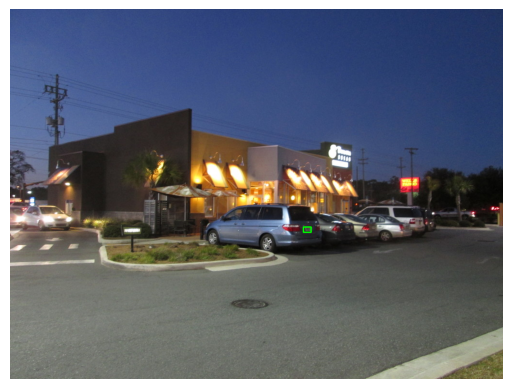

In [31]:
# Plot sample image with bounding boxes
def samplePlot(dataframe):
    row = dataframe.sample(n=1)
    image, x1, y1, x2, y2 = row.iloc[0]
    path = f"./data/imgs/{image}.jpg"
    img = cv2.imread(path)
    w, h, d = img.shape

    # Open CV uses (x, y) coordinates of the top-left corner and the bottom-right corner
    x1 = int(x1*img.shape[1])
    y1 = int(y1*img.shape[0])
    x2 = int(x2*img.shape[1])
    y2 = int(y2*img.shape[0])
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

samplePlot(df)

## License detection model

In [32]:
# Convert images to array with VOC format labels
def convert_to_array(df):
    data = []
    output = []

    for i in range(len(df)):
        image, x1, y1, x2, y2 = df.iloc[i]
        img_path = f"{image_folder}{image}.jpg"
        h,w,d = cv2.imread(img_path).shape

        # Preprocess the image
        img_array = img_to_array(load_img(img_path, target_size=(224, 224)))
        img_array = img_array / 255.0

        data.append(img_array)
        output.append((x1, y1, x2, y2))

    return np.array(data, dtype=np.float32), np.array(output, dtype=np.float32)


In [33]:
# Save the data in a compressed file
def save_split_data(X, y, filename):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train.shape, X_test.shape, y_train.shape, y_test.shape

    np.savez_compressed(filename, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

X, y = convert_to_array(df)
save_split_data(X, y, "data.npz")

### Training


In [34]:
# This function is run in another script
def train_model():
    inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

    head_model = inception_resnet.output
    head_model = Flatten()(head_model)
    head_model = Dense(500,activation="relu")(head_model)
    head_model = Dense(250,activation="relu")(head_model)
    head_model = Dense(4,activation='sigmoid')(head_model)

    model = Model(inputs=inception_resnet.input, outputs=head_model)

    model.compile(loss="mean_squared_error", optimizer="adam")
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=16)
    model.save("plate_detection.h5")

### Predictions

In [35]:
# Load model on CPU
test_df = load_dataframe(test_folder)
# model = tf.keras.models.load_model("plate_detection2.h5")

In [36]:
test_df.head()

,image,x1,y1,x2,y2
0,944281d0485869f0,0.402946,0.611660,0.619719,0.818957
1,87793700161a7a6b,0.440106,0.663790,0.707712,0.761372
2,b076ad266891d7aa,0.144969,0.803906,0.173489,0.849459
3,b076ad266891d7aa,0.912375,0.706830,0.953630,0.722431
4,4e593c88022ff6b1,0.577957,0.573201,0.689988,0.667687


In [37]:
# Print image row 16789af24af158d8
row = test_df[test_df["image"] == "16789af24af158d8"]
print(row)

                image        x1        y1        x2        y2
184  16789af24af158d8  0.256826  0.452112  0.622301  0.552095


In [38]:
# Plot a sample prediction
def sample_prediction(dataframe, model, img_folder):
    row = dataframe.sample(n=1)
    image_path, x1, y1, x2, y2 = row.iloc[0]

    print("Loading image:", image_path)
    path = f"{img_folder}{image_path}.jpg"
    orginal_img = load_img(path)
    height, width, depth = np.array(orginal_img).shape

    img_array = img_to_array(load_img(path, target_size=(224, 224)))
    img_array = img_array / 255.0
    img_array = img_array.reshape(1, 224, 224, 3)
    p_x1, p_y1, p_x2, p_y2 = model.predict(img_array)[0]

    print("Predicted coordinates:", p_x1, p_y1, p_x2, p_y2)
    print("Actual coordinates:", x1, y1, x2, y2)
    
    # Denormalize the coordinates
    p_x1 = int(p_x1 * width)
    p_y1 = int(p_y1 * height)
    p_x2 = int(p_x2 * width)
    p_y2 = int(p_y2 * height)

    x1 = int(x1 * width)
    y1 = int(y1 * height)
    x2 = int(x2 * width)
    y2 = int(y2 * height)

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
    img = cv2.rectangle(img, (p_x1, p_y1), (p_x2, p_y2), (0,255,0), 2)
    plt.imshow(img)
        

# sample_prediction(test_df, model, test_folder)

In [39]:
# Make prediction on testing set, calculate accuracy metrics
def predict_and_plot(model, test_df):
    X_test, y_test = convert_to_array(test_df)
    y_pred = model.predict(X_test)
    ious = []

    for i in range(len(X_test)):
        image, x_center, y_center, width, height = test_df.iloc[i]
        path = f"{test_folder}{image}.jpg"
        x_center_pred, y_center_pred, width_pred, height_pred = y_pred[i]
    
        # Calculate accuracy
        x_min, y_min, x_max, y_max = yolo_to_voc(x_center, y_center, width, height, 224, 224)
        x_min_pred, y_min_pred, x_max_pred, y_max_pred = yolo_to_voc(x_center_pred, y_center_pred, width_pred, height_pred, 224, 224)

        # Calculate IOU
        xA = max(x_min, x_min_pred)
        yA = max(y_min, y_min_pred)
        xB = min(x_max, x_max_pred)
        yB = min(y_max, y_max_pred)

        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (x_max - x_min + 1) * (y_max - y_min + 1)
        boxBArea = (x_max_pred - x_min_pred + 1) * (y_max_pred - y_min_pred + 1)
        iou = interArea / float(boxAArea + boxBArea - interArea)
        ious.append(iou)

    # Plot ious
    plt.hist(ious, bins=20)
    plt.xlabel("IOU")
    plt.ylabel("Frequency")
    plt.show()

# predict_and_plot(model, test_df)